## Bear Classifier

### I. Gather Data

In [20]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [21]:
from fastbook import *
from fastai.vision.widgets import *

In [22]:
!pip install nbdev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
# DDG search image function
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [24]:
# Download 200 images of grizzly bears
ims = search_images_ddg("grizzly bear")
len(ims)

200

In [25]:
# Take a look at the first picture
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

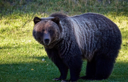

In [26]:
# Display first picture
im = Image.open(dest)
im.to_thumb(128,128)

In [27]:
# Download and organize images for all of our search terms in separate folders
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [28]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f"{o} bear")
        download_images(dest, urls=results)

In [29]:
# Check paths to make sure everything is working correctly
fns = get_image_files(path)
fns

(#566) [Path('bears/teddy/3f69759a-bc9f-4dbd-b181-033d2f484e09.jpg'),Path('bears/teddy/b409a1e6-2b99-4631-b05d-bf6ac7b01f47.jpg'),Path('bears/teddy/03d3d502-ffa8-45ac-9066-707fd0146e71.jpg'),Path('bears/teddy/9b24ba5d-6b18-4907-9be4-448393cca5dc.jpg'),Path('bears/teddy/96cd9fd5-a259-496a-8ab9-20a212e8cee0.JPG'),Path('bears/teddy/2d4d8c3e-7e74-41b3-8357-49575cd74377.jpeg'),Path('bears/teddy/ef48a86a-1c83-4ad5-91b8-6ac9662117e4.jpg'),Path('bears/teddy/3b836a14-1e7d-4e8d-bbb4-426db129c742.jpg'),Path('bears/teddy/cd18fa1b-6f2d-4d6b-b3f1-e77290bff282.jpeg'),Path('bears/teddy/cb594da7-bbe9-4e9f-88a2-31a7a125b06e.jpeg')...]

In [30]:
# Check if there are corrupt files
failed = verify_images(fns)
failed

(#0) []

In [31]:
# Remove all corrupt images
failed.map(Path.unlink);

### Prep Data for Training

In [32]:
# Create DataBlock to prep data for training
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [33]:
# Specify source of the data
dls = bears.dataloaders(path)

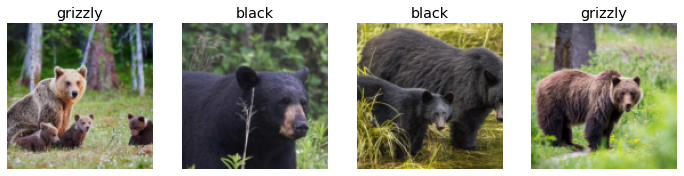

In [34]:
# Show batch of images in tensor
dls.valid.show_batch(max_n=4, nrows=1)

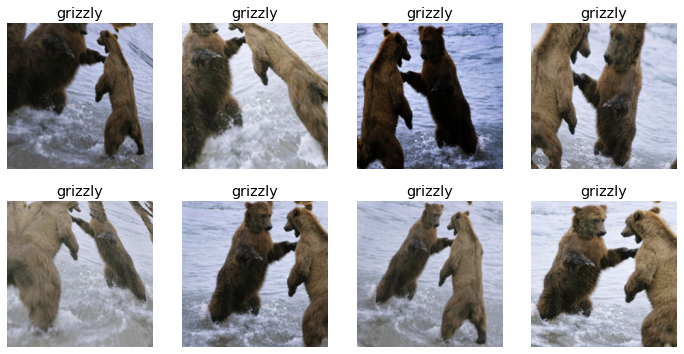

In [35]:
# Data augmentation
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Training

In [36]:
# Train model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.034431,0.057877,0.026549,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.213164,0.041213,0.008850,00:13
1,0.175610,0.041372,0.017699,00:13
2,0.145738,0.038079,0.017699,00:13
3,0.138260,0.040352,0.017699,00:12


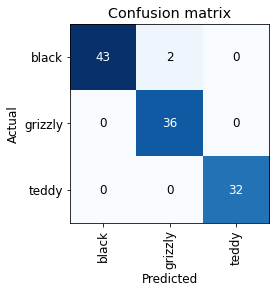

In [37]:
# Confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

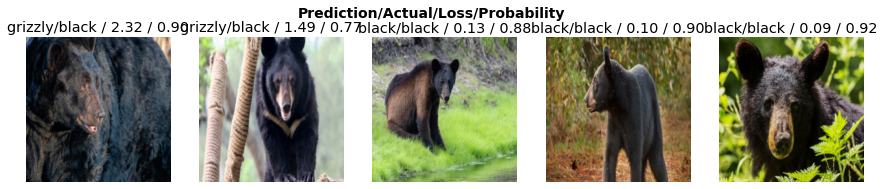

In [38]:
# Images with highest loss in our dataset
interp.plot_top_losses(5, nrows=1)